In [18]:
!pip install --user PyALE
import PyALE
from PyALE import ale

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score

from sklearn.model_selection import cross_validate

!pip install xgboost
import xgboost as xgb


  Using cached xgboost-1.6.2-py3-none-manylinux2014_x86_64.whl (255.9 MB)


In [3]:
df=pd.read_csv('/home/jupyter/churn&cluster_v2_04_02.csv')

In [4]:
df=df.drop("Unnamed: 0", axis=1)
df.dropna(subset = ['churn'],inplace = True)

In [5]:
# Create 8 separate dataframes based on the cluster column
df_list = [df[df['cluster']==i] for i in range(8)]

# Assign separate dataframes to variables
df_cluster0, df_cluster1, df_cluster2, df_cluster3, df_cluster4, df_cluster5, df_cluster6, df_cluster7 = df_list

In [7]:
columns=['churn','avg_time_btw_orders', 'recency', 'months_elapsed',
       'purchase_times', 'lifetime_spent', 'lifetime_quantity',
       'per_order_spent', 'per_order_quantity', 'distinct_category_count',
       'discount_frequency_order', 'discount_frequency_product',
       'outdoor_equipment_pct', 'cargo_pct', 'soft_cooler_pct', 'bags_pct',
       'drinkware_pct', 'hard_cooler_pct', 'other_pct', 'black_pct',
       'white_pct', 'navy_pct', 'seaform_pct', 'stainless_pct', 'charcoal_pct',
       'nordic_purple_pct', 'harvest_red_pct', 'alpine_yellow_pct',
       'other_color_pct', 'product_added_count',
       'product_added_to_wishlist_count', 'product_removed_count',
       'customizer_started_count', 'customizer_completed_count',
       'cart_viewed_count', 'checkout_started_count', 'order_cancelled_count',
       'email_received', 'email_open_rate', 'max_entry_product_price',
       'unsubscribed_0.0', 'unsubscribed_1.0', 'unsubscribed_2.0']

for i in range(0,8):
    df = globals()['df_cluster{}'.format(i)]
    new_df = df[columns]
    globals()['df_cluster_short{}'.format(i)] = new_df

In [12]:

# create an empty dataframe to store the computation time
Xgb_time=pd.DataFrame(columns=["Cluster","Time"])

# create an empty dataframe to store the feature importance scores
feature_importance_df = pd.DataFrame(columns=['Cluster', 'Feature', 'Importance'])

for i in range(0, 8):
    start_time = time.time() # Start the timer
    df_ada = globals()['df_cluster_short{}'.format(i)]
    df_ada=df_ada.drop(['avg_time_btw_orders', 'recency'],axis=1)

    y_data=df_ada.churn
    x_data=df_ada.drop(['churn'],axis=1)
    
    #noise = np.random.rand(len(x_data), 1)

    # concatenate the noise array with your feature matrix
    #x_data = np.concatenate((x_data, noise), axis=1)

    
    
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data,test_size=0.2, random_state = 42
                                                       )
    
    Xgb_clf = xgb.XGBClassifier(max_depth=2,n_estimators=150,learning_rate=0.5)
    
    
    # Cross-validation
    #cv_results = cross_validate(Ada_clf, X_train, y_train, cv=5, scoring='accuracy')
    #cv_accuracy = cv_results['test_score']
    #print("cluster {}'s Cross Validation Accuracy:".format(i), cv_accuracy.mean())
    
    
    Xgb_clf.fit(X_train, y_train)
    
    ypred=Xgb_clf.predict(X_test) #These are the predicted output values
    
    # Get the feature importance scores for testing sets!!!!
    feature_importances = Xgb_clf.feature_importances_

    # add the feature importance scores to the dataframe
    for j in range(len(feature_importances)):
        feature_importance_df = feature_importance_df.append({'Cluster': i, 'Feature': x_data.columns[j], 'Importance': feature_importances[j]}, ignore_index=True)
    
    
    result = confusion_matrix(y_test, ypred)
    end_time = time.time() # End the timer
    print("cluster {}'s Confusion Matrix:".format(i))
    print(result)

    result1 = classification_report(y_test, ypred)
    print("cluster {}'s Classification Report:".format(i))
    print (result1)

    result2 = accuracy_score(y_test,ypred)
    print("cluster {}'s Accuracy:".format(i),result2,"\n")
    

    time_lapse=end_time - start_time
    Xgb_time.loc[i]=[i,time_lapse]

    print("cluster {}'s Computation Time:".format(i),time_lapse, "\n") # Print the computation time
    

cluster 0's Confusion Matrix:
[[7365 1628]
 [1990 4181]]
cluster 0's Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.80      8993
         1.0       0.72      0.68      0.70      6171

    accuracy                           0.76     15164
   macro avg       0.75      0.75      0.75     15164
weighted avg       0.76      0.76      0.76     15164

cluster 0's Accuracy: 0.7614085993141652 

cluster 0's Computation Time: 20.21899104118347 

cluster 1's Confusion Matrix:
[[5386 2552]
 [1376 9642]]
cluster 1's Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.68      0.73      7938
         1.0       0.79      0.88      0.83     11018

    accuracy                           0.79     18956
   macro avg       0.79      0.78      0.78     18956
weighted avg       0.79      0.79      0.79     18956

cluster 1's Accuracy: 0.7927832876134205 

cluster 1's Computation Ti

In [13]:
# pivot the feature_importance_df dataframe to a wide format
feature_importance_wide = feature_importance_df.pivot(index='Cluster', columns='Feature', values='Importance')
f_sort=feature_importance_wide.T
f_sort["Average"]=(feature_importance_wide.T[0]+feature_importance_wide.T[7]+feature_importance_wide.T[1]+feature_importance_wide.T[2]
                                    +feature_importance_wide.T[3]+feature_importance_wide.T[4]+feature_importance_wide.T[5]+feature_importance_wide.T[6])/7
f_sort=f_sort.sort_values("Average",ascending=False)

f_sort.style.format("{:.2f}").background_gradient(cmap='coolwarm')

Cluster,0,1,2,3,4,5,6,7,Average
Feature,,,,,,,,,
nordic_purple_pct,0.35,0.19,0.21,0.17,0.18,0.13,0.39,0.11,0.24
cart_viewed_count,0.09,0.06,0.08,0.08,0.06,0.08,0.04,0.08,0.08
alpine_yellow_pct,0.17,0.06,0.05,0.06,0.05,0.04,0.09,0.02,0.08
discount_frequency_order,0.03,0.05,0.04,0.03,0.01,0.06,0.04,0.22,0.07
months_elapsed,0.02,0.09,0.06,0.10,0.03,0.07,0.05,0.04,0.06
customizer_started_count,0.02,0.05,0.11,0.08,0.02,0.08,0.05,0.01,0.06
charcoal_pct,0.04,0.03,0.10,0.01,0.08,0.01,0.06,0.09,0.06
distinct_category_count,0.01,0.00,0.00,0.05,0.18,0.16,0.00,0.01,0.06
customizer_completed_count,0.02,0.03,0.01,0.02,0.18,0.02,0.01,0.11,0.06


In [24]:
df0 = df_cluster_short0.copy()
df0.drop(['avg_time_btw_orders', 'recency'],axis=1,inplace=True)
y_data=df0.churn
x_data=df0.drop(['churn'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data,test_size=0.2, random_state = 42)

In [26]:
Xgb_clf = xgb.XGBClassifier(max_depth=2,n_estimators=150,learning_rate=0.5)   
Xgb_clf.fit(X_train, y_train)  
ypred=Xgb_clf.predict(X_test) #These are the predicted output values


In [12]:
pip install cymem


  Using cached cymem-2.0.7-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36 kB)
Note: you may need to restart the kernel to use updated packages.


In [17]:
from alibi.explainers import ALE

# define a predictor function that wraps the predict_proba method of the Xgb_clf model
# get feature importance scores and sort in descending order
feature_importance = Xgb_clf.feature_importances_
sorted_idx = feature_importance.argsort()[::-1]

# get the top three important features
top_three = sorted_idx[:3]

ale = ALE(predictor=Xgb_clf.predict_proba, feature_names=X_train.columns)
# ale = ALE(X_train.columns[i])

for i in top_three:    
    # fit the ALE object to the training data and compute the ALE values for the testing data
    ale.fit_transform(X_train.iloc[:, i].values.reshape(-1, 1), Xgb_clf.predict_proba)
    ale_values = ale.explain(X_test.iloc[:, i].values.reshape(-1, 1))
    
    # plot the ALE curve
    ale_plot = ale.plot(xticks_rotation=45)
    ale_plot.set_title("ALE Plot for {}".format(X_train.columns[i]))
    ale_plot.set_xlabel(X_train.columns[i])
    ale_plot.set_ylabel("ALE Value")
    ale_plot.show()

AttributeError: 'ALE' object has no attribute 'fit_transform'

In [28]:
X_train.columns[top_three]

Index(['purchase_times', 'months_elapsed', 'product_removed_count'], dtype='object')

PyALE._ALE_generic:INFO: Continuous feature detected.


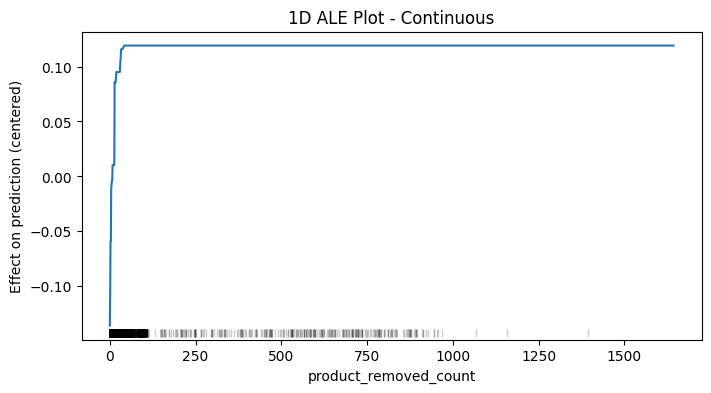

In [34]:
ale_eff = ale(X=X_test, model=Xgb_clf, feature=["product_removed_count"], 
              grid_size=50, include_CI=False)

PyALE._ALE_generic:INFO: Continuous feature detected.


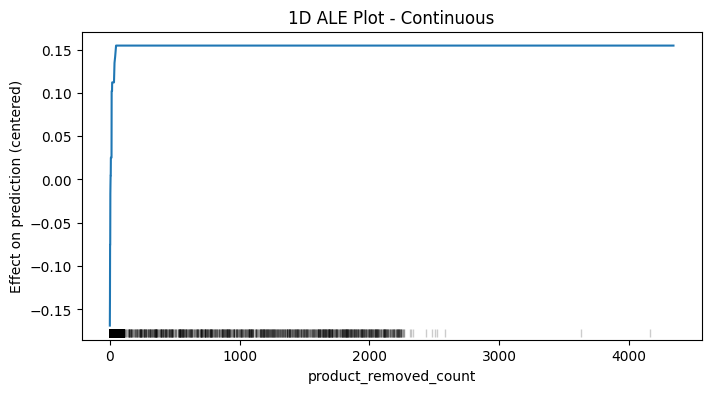

In [33]:
ale_eff = ale(X=X_train, model=Xgb_clf, feature=["product_removed_count"], 
              grid_size=50, include_CI=False)